### Import required libraries

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy.stats as stats

### Setup plotting style

In [2]:
# Use a compatible matplotlib style and seaborn settings
plt.style.use('default')  # Use default matplotlib style
sns.set_theme(style="darkgrid")  # Modern seaborn theme setting
sns.set_palette("husl")
%matplotlib inline

# Additional styling for better plots
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

### Load the data

In [3]:
'''
    Test Case 1:
          - Train client is a Laptop connected to 5G network
          - Web client is a Laptop connected to 5G network
'''
filename =  './29_08_2025/pre_processed/processed_Train_Client(Laptop)_Web_Client(Laptop)_e1c07b43-9e1e-4438-ade8-a320a030e494_Latency.json'


'''
    Test Case 2:
          - Train client is a Laptop connected to 5G network
          - Web client is a Phone connected to 5G network
'''
#filename =  './29_08_2025/pre_processed/processed_Train_Client(Laptop)_Web_Client(Mobile_DE)_5d6a5a85-6566-45b9-8b57-48e886539e0b_Latency.json'


'''
    Test Case 3:
          - Train client is a Laptop connected to 5G network (Germany)
          - Web client is a Phone connected to 5G network (Bangladesh)
'''
#filename =  './29_08_2025/pre_processed/processed_Train_Client(Laptop)_Web_Client(Mobile_BD)_1bdb4d47-a2e0-4148-a721-796cf6ff755b_Latency.json'



with open(filename, 'r') as file:
    data = json.load(file)

print(f"Data loaded successfully from {filename}")
print(f"Data type: {type(data)}")
print(f"Data keys: {list(data.keys()) if isinstance(data, dict) else 'Not a dictionary'}")

# Convert to DataFrames for easier analysis
telemetry_df = pd.DataFrame(data['telemetryLatencies'])
video_df = pd.DataFrame(data['videoLatencies'])

# Create a summary DataFrame from statistics
protocols = ['websocket', 'webtransport', 'mqtt']
stats_data = []
for protocol in protocols:
    stats_data.append({
        'protocol': protocol,
        'count': data['statistics'][protocol]['count'],
        'avg': data['statistics'][protocol]['avg'],
        'min': data['statistics'][protocol]['min'],
        'max': data['statistics'][protocol]['max']
    })
stats_df = pd.DataFrame(stats_data)

Data loaded successfully from ./29_08_2025/pre_processed/processed_Train_Client(Laptop)_Web_Client(Laptop)_e1c07b43-9e1e-4438-ade8-a320a030e494_Latency.json
Data type: <class 'dict'>
Data keys: ['exportTime', 'statistics', 'telemetryLatencies', 'videoLatencies', 'processingTime', 'originalFile']


#### 1.1 Basic Statistics Comparison

In [4]:
print("Protocol Statistics Comparison:")
print(stats_df)

Protocol Statistics Comparison:
       protocol  count         avg   min     max
0     websocket    260  141.911538  48.5  2534.5
1  webtransport    232  135.443966  49.5  2424.5
2          mqtt    262   81.320611  30.5  2355.5


#### 1.2 Visualization of protocol performance

Missing values in telemetry data:
MQTT: 67
WebTransport: 97
WebSocket: 69


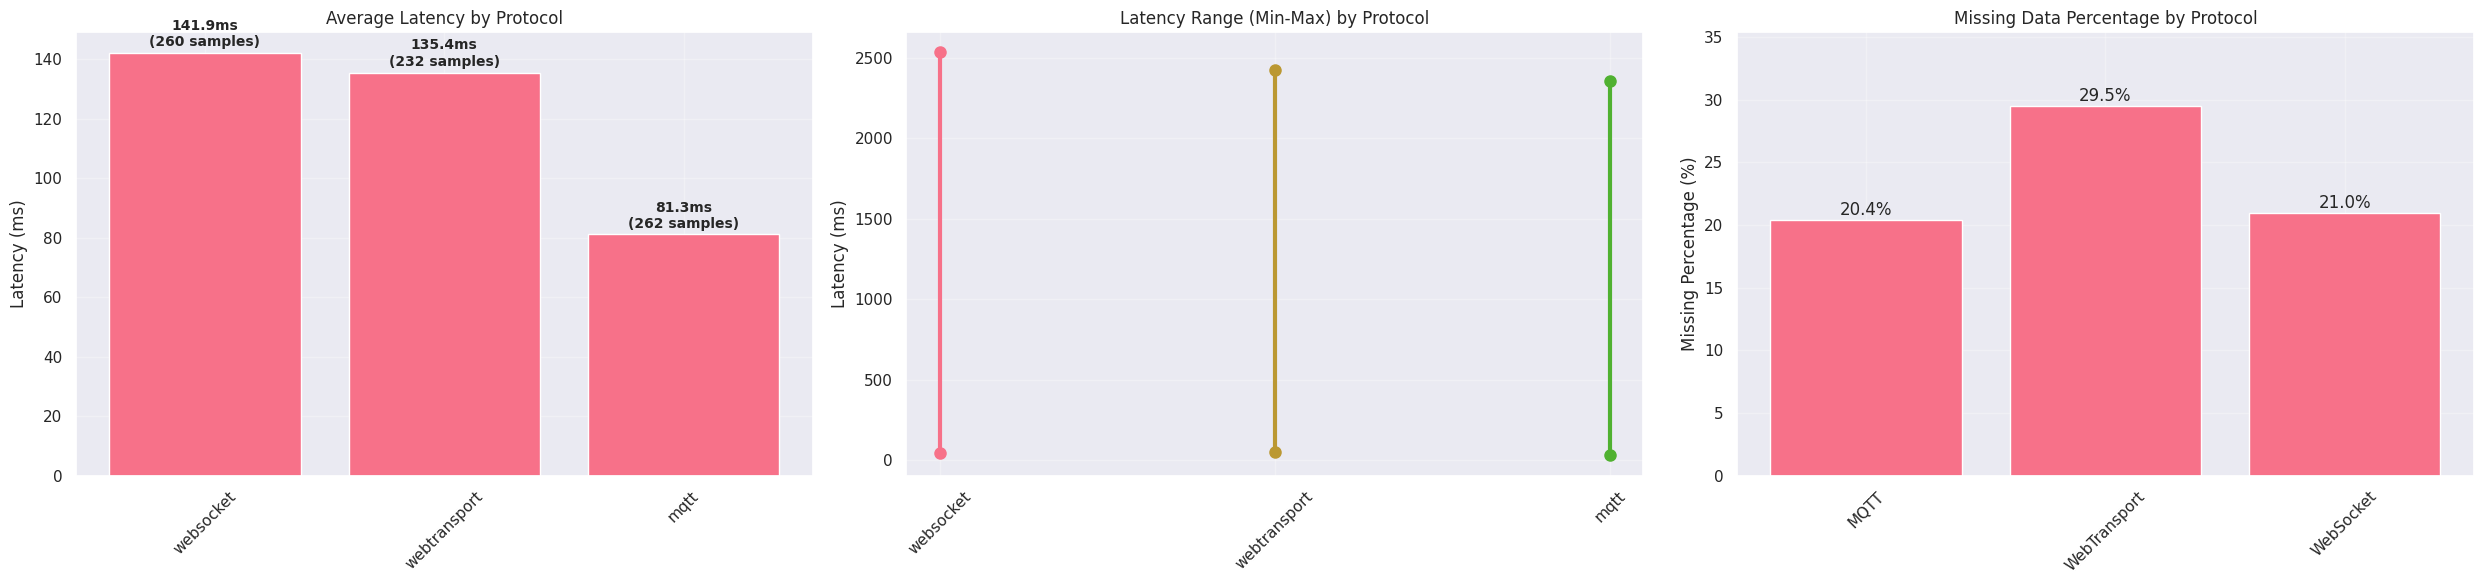


Missing data percentages:
MQTT: 20.36%
WebTransport: 29.48%
WebSocket: 20.97%

Telemetry data processed by each protocol:
websocket: 260 samples
webtransport: 232 samples
mqtt: 262 samples


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(25, 6))

# Average latency by protocol with data count labels
bars_avg = axes[0].bar(stats_df['protocol'], stats_df['avg'])
axes[0].set_title('Average Latency by Protocol')
axes[0].set_ylabel('Latency (ms)')
axes[0].tick_params(axis='x', rotation=45)

# Add count labels on top of average latency bars
for i, (bar, row) in enumerate(zip(bars_avg, stats_df.itertuples())):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{row.avg:.1f}ms\n({row.count} samples)', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Min-Max latency range
for i, row in stats_df.iterrows():
    axes[1].plot([row['protocol'], row['protocol']], [row['min'], row['max']],
                   marker='o', linewidth=3, markersize=8)
axes[1].set_title('Latency Range (Min-Max) by Protocol')
axes[1].set_ylabel('Latency (ms)')
axes[1].tick_params(axis='x', rotation=45)

# Check for missing values in telemetry data
print("Missing values in telemetry data:")
print(f"MQTT: {telemetry_df['mqtt'].isna().sum()}")
print(f"WebTransport: {telemetry_df['wt'].isna().sum()}")
print(f"WebSocket: {telemetry_df['ws'].isna().sum()}")

# Calculate missing percentages
total_records = len(telemetry_df)
missing_percentages = {
    'MQTT': (telemetry_df['mqtt'].isna().sum() / total_records) * 100,
    'WebTransport': (telemetry_df['wt'].isna().sum() / total_records) * 100,
    'WebSocket': (telemetry_df['ws'].isna().sum() / total_records) * 100
}

# Missing percentage by protocol
protocols_missing = list(missing_percentages.keys())
percentages = list(missing_percentages.values())

bars = axes[2].bar(protocols_missing, percentages)
axes[2].set_title('Missing Data Percentage by Protocol')
axes[2].set_ylabel('Missing Percentage (%)')
axes[2].tick_params(axis='x', rotation=45)

# Add percentage labels on top of bars
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{percentage:.1f}%', ha='center', va='bottom')

# Set y-axis limit for better visualization
axes[2].set_ylim(0, max(percentages) * 1.2 if max(percentages) > 0 else 10)

plt.tight_layout()
plt.show()

print(f"\nMissing data percentages:")
for protocol, percentage in missing_percentages.items():
    print(f"{protocol}: {percentage:.2f}%")

# Print telemetry data count summary
print(f"\nTelemetry data processed by each protocol:")
for _, row in stats_df.iterrows():
    print(f"{row['protocol']}: {row['count']} samples")

#### 2.1 Time Series analysis of telemetry data

In [6]:
# Check data shape and info
print(f"\nTelemetry data shape: {telemetry_df.shape}")
print(f"Sequence ID range: {telemetry_df['sequence_id'].min()} - {telemetry_df['sequence_id'].max()}")

# Display first few rows to understand the data structure
print("\nFirst 10 rows of telemetry data:")
print(telemetry_df.head(10))


Telemetry data shape: (329, 4)
Sequence ID range: 79 - 343

First 10 rows of telemetry data:
   sequence_id   mqtt     wt     ws
0           79   52.5   70.5   90.5
1           80   52.5   66.5  100.5
2           81   39.5  127.5  160.5
3           82  182.5  196.5  186.5
4           83   40.5   98.5   91.5
5           84   36.5  127.5  137.5
6           85   40.5  119.5    NaN
7           86   44.5  128.5    NaN
8           87   47.5    NaN  263.5
9           88   39.5    NaN  152.5


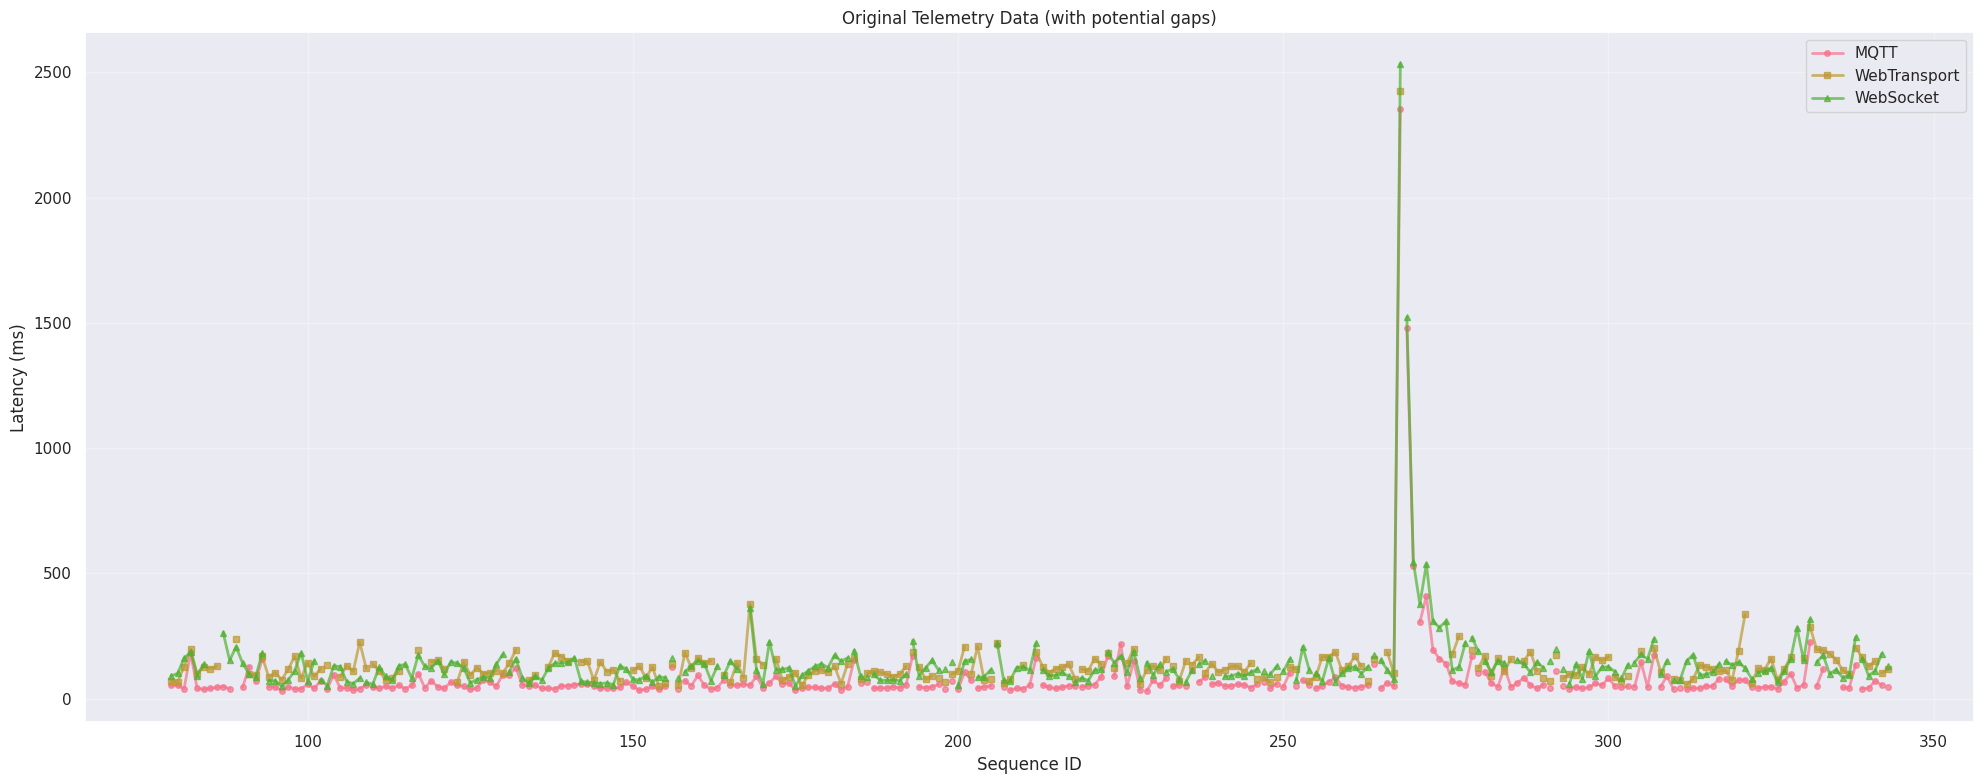

In [7]:
# Comparison: Original data with gaps vs Interpolated data
fig, ax1 = plt.subplots(1, 1, figsize=(20, 8))

# Original data (with potential gaps)
ax1.plot(telemetry_df['sequence_id'], telemetry_df['mqtt'], marker='o', label='MQTT', linewidth=2, markersize=4, alpha=0.7)
ax1.plot(telemetry_df['sequence_id'], telemetry_df['wt'], marker='s', label='WebTransport', linewidth=2, markersize=4, alpha=0.7)
ax1.plot(telemetry_df['sequence_id'], telemetry_df['ws'], marker='^', label='WebSocket', linewidth=2, markersize=4, alpha=0.7)
ax1.set_xlabel('Sequence ID')
ax1.set_ylabel('Latency (ms)')
ax1.set_title('Original Telemetry Data (with potential gaps)')
ax1.legend()
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 2.2 Cumulative Latency Analysis for telemetry data

In [8]:
# Create cumulative latency data with interpolation for null values
telemetry_clean_cumulative = telemetry_df.copy()

# First, interpolate null values for each protocol
print("Before interpolation:")
print(f"MQTT null values: {telemetry_clean_cumulative['mqtt'].isna().sum()}")
print(f"WebTransport null values: {telemetry_clean_cumulative['wt'].isna().sum()}")
print(f"WebSocket null values: {telemetry_clean_cumulative['ws'].isna().sum()}")

# Interpolate missing values using linear interpolation
telemetry_clean_cumulative['mqtt'] = telemetry_clean_cumulative['mqtt'].interpolate(method='linear')
telemetry_clean_cumulative['wt'] = telemetry_clean_cumulative['wt'].interpolate(method='linear')
telemetry_clean_cumulative['ws'] = telemetry_clean_cumulative['ws'].interpolate(method='linear')

print("\nAfter interpolation:")
print(f"MQTT null values: {telemetry_clean_cumulative['mqtt'].isna().sum()}")
print(f"WebTransport null values: {telemetry_clean_cumulative['wt'].isna().sum()}")
print(f"WebSocket null values: {telemetry_clean_cumulative['ws'].isna().sum()}")

# Calculate cumulative latencies for each protocol
telemetry_clean_cumulative['mqtt_cumulative'] = telemetry_clean_cumulative['mqtt'].cumsum()
telemetry_clean_cumulative['wt_cumulative'] = telemetry_clean_cumulative['wt'].cumsum()
telemetry_clean_cumulative['ws_cumulative'] = telemetry_clean_cumulative['ws'].cumsum()

print("\nCumulative latency data created successfully!")
print(f"Shape: {telemetry_clean_cumulative.shape}")
print("\nFirst 10 rows of cumulative data:")
print(telemetry_clean_cumulative[['sequence_id', 'mqtt_cumulative', 'wt_cumulative', 'ws_cumulative']].head(10))
print("\nLast 10 rows of cumulative data:")
print(telemetry_clean_cumulative[['sequence_id', 'mqtt_cumulative', 'wt_cumulative', 'ws_cumulative']].tail(10))

Before interpolation:
MQTT null values: 67
WebTransport null values: 97
WebSocket null values: 69

After interpolation:
MQTT null values: 0
WebTransport null values: 0
WebSocket null values: 0

Cumulative latency data created successfully!
Shape: (329, 7)

First 10 rows of cumulative data:
   sequence_id  mqtt_cumulative  wt_cumulative  ws_cumulative
0           79             52.5      70.500000           90.5
1           80            105.0     137.000000          191.0
2           81            144.5     264.500000          351.5
3           82            327.0     461.000000          538.0
4           83            367.5     559.500000          629.5
5           84            404.0     687.000000          767.0
6           85            444.5     806.500000          946.5
7           86            489.0     935.000000         1168.0
8           87            536.5    1100.166667         1431.5
9           88            576.0    1302.000000         1584.0

Last 10 rows of cumulative

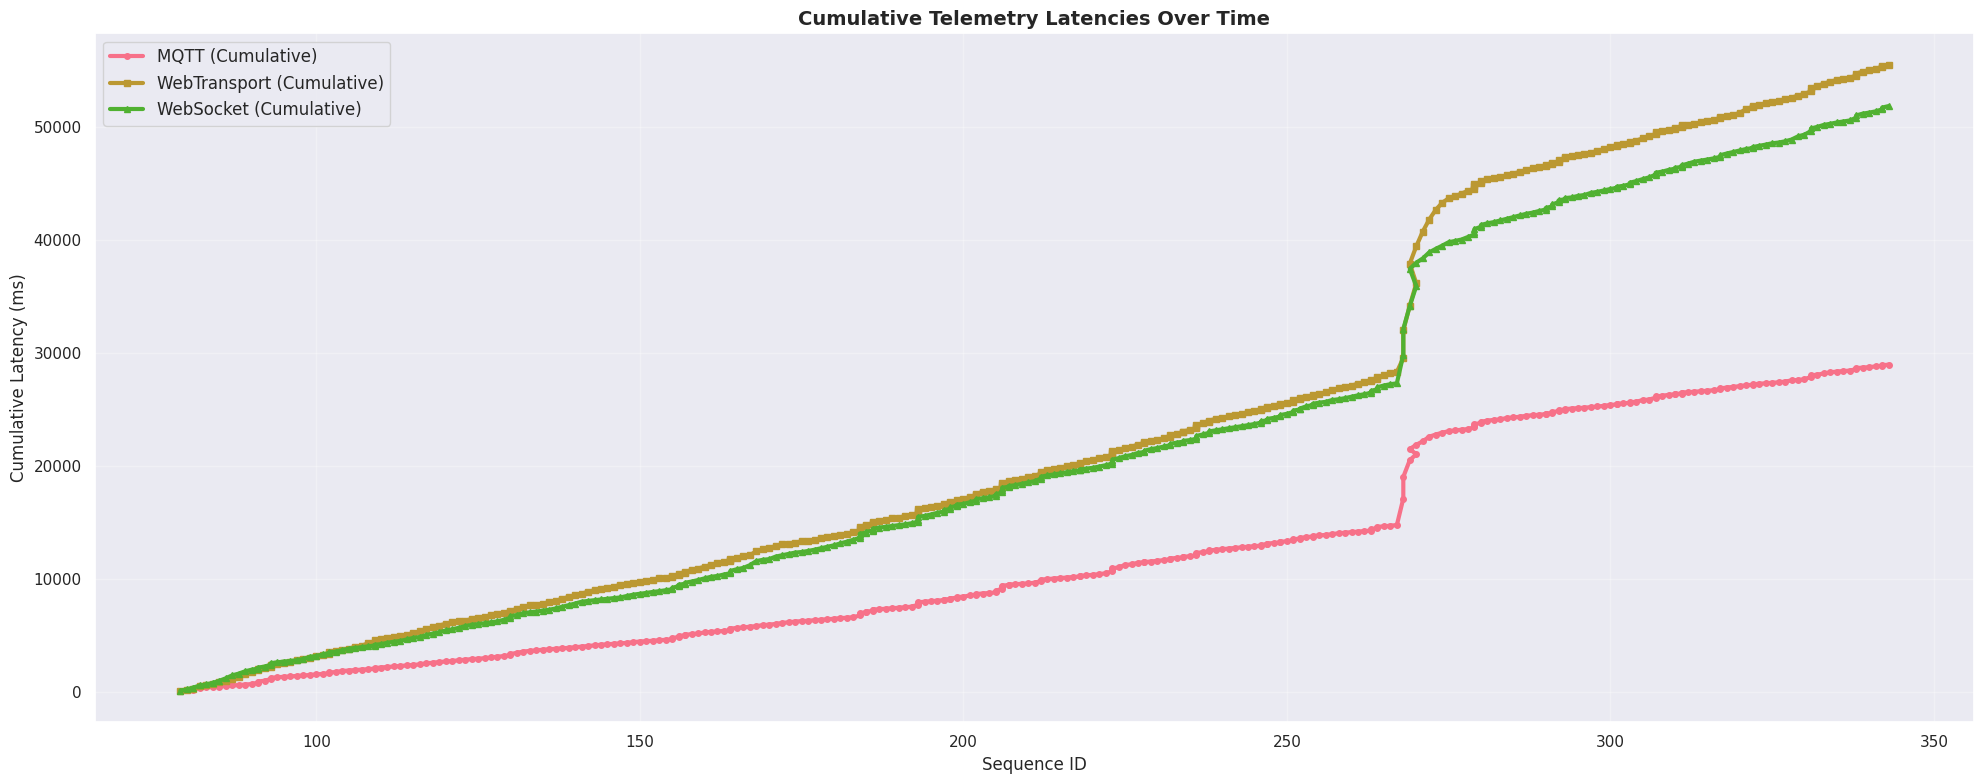

In [9]:
# Plot cumulative latencies
plt.figure(figsize=(20, 8))
plt.plot(telemetry_clean_cumulative['sequence_id'], telemetry_clean_cumulative['mqtt_cumulative'],
         marker='o', label='MQTT (Cumulative)', linewidth=3, markersize=4)
plt.plot(telemetry_clean_cumulative['sequence_id'], telemetry_clean_cumulative['wt_cumulative'],
         marker='s', label='WebTransport (Cumulative)', linewidth=3, markersize=4)
plt.plot(telemetry_clean_cumulative['sequence_id'], telemetry_clean_cumulative['ws_cumulative'],
         marker='^', label='WebSocket (Cumulative)', linewidth=3, markersize=4)

plt.xlabel('Sequence ID', fontsize=12)
plt.ylabel('Cumulative Latency (ms)', fontsize=12)
plt.title('Cumulative Telemetry Latencies Over Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### 3. Video Frame Latency Analysis

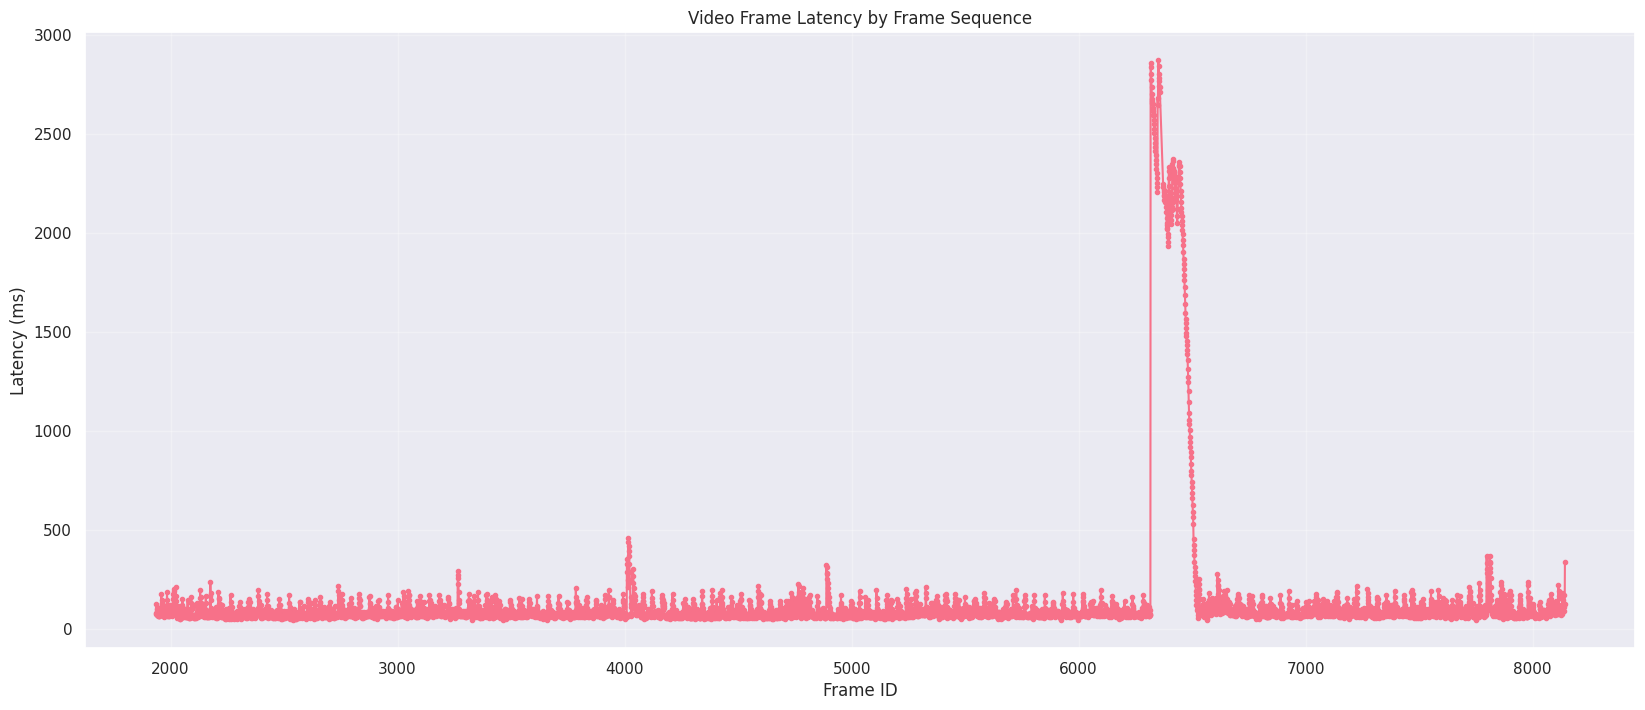

In [10]:
# 3.1 Time series analysis of video latencies
plt.figure(figsize=(20, 8))

# Latency over frame sequence
plt.plot(video_df['frameId'], video_df['latency'], marker='o', markersize=3)
plt.xlabel('Frame ID')
plt.ylabel('Latency (ms)')
plt.title('Video Frame Latency by Frame Sequence')
plt.grid(True, alpha=0.3)
plt.show()

First received frame ID: 1935
Last received frame ID: 8142
Total expected frames in sequence: 6208
Number of received frames: 6180
Number of missing frames: 28
Missing frame percentage: 0.45%

Missing frame IDs: [3655, 4015, 4024, 4025, 5318, 6350, 6359, 6360, 6361, 6362, 6363, 6364, 6365, 6366, 6367, 6368, 6369, 6370, 6371, 6435, 6436, 6437, 6438, 6439, 6440, 6441, 7269, 7809]


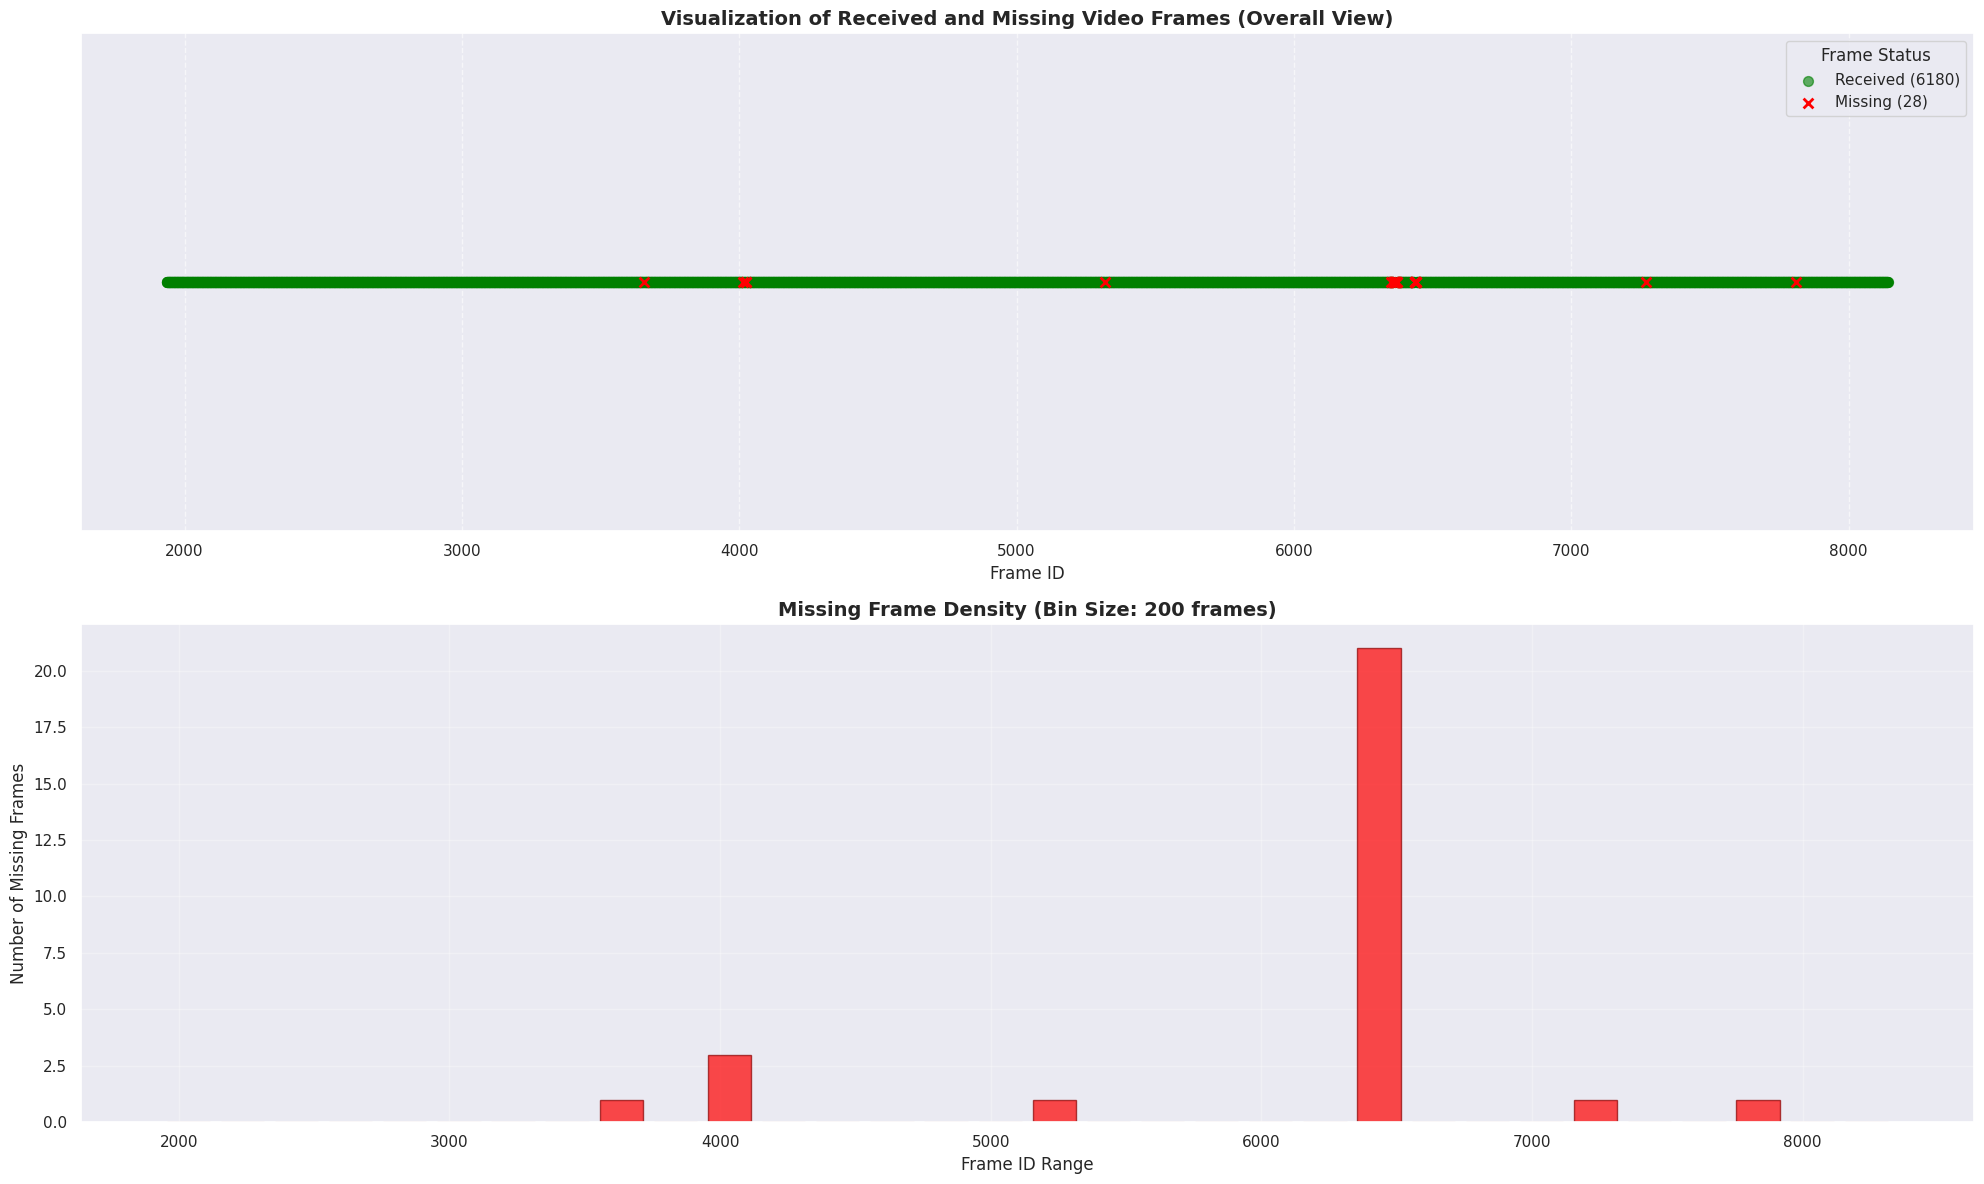


Missing Frame Analysis:
- First missing frame: 3655
- Last missing frame: 7809
- Average gap between consecutive missing frames: 153.9
- Largest gap between consecutive missing frames: 1293


In [11]:
# 3.2 Analysis of missing video frames
if not video_df.empty:
    # Find the first and last frame IDs
    first_frame_id = video_df['frameId'].min()
    last_frame_id = video_df['frameId'].max()

    # Calculate the total number of expected frames
    total_expected_frames = last_frame_id - first_frame_id + 1

    # Calculate the number of received frames
    received_frames_count = len(video_df)

    # Calculate the number of missing frames
    missing_frames_count = total_expected_frames - received_frames_count

    print(f"First received frame ID: {first_frame_id}")
    print(f"Last received frame ID: {last_frame_id}")
    print(f"Total expected frames in sequence: {total_expected_frames}")
    print(f"Number of received frames: {received_frames_count}")
    print(f"Number of missing frames: {missing_frames_count}")
    print(f"Missing frame percentage: {(missing_frames_count/total_expected_frames)*100:.2f}%")

    # Identify the missing frame IDs
    expected_frame_ids = set(range(first_frame_id, last_frame_id + 1))
    received_frame_ids = set(video_df['frameId'])
    missing_frame_ids = sorted(list(expected_frame_ids - received_frame_ids))

    print(f"\nMissing frame IDs: {missing_frame_ids if missing_frames_count > 0 else 'None'}")

    # Create visualizations
    fig, axes = plt.subplots(2, 1, figsize=(20, 12))
    
    # 1. Overall view with improved markers
    all_frames = pd.DataFrame({'frameId': list(range(first_frame_id, last_frame_id + 1))})
    all_frames['status'] = 'Missing'
    all_frames.loc[all_frames['frameId'].isin(received_frame_ids), 'status'] = 'Received'
    
    # Plot with larger, more visible markers
    received_data = all_frames[all_frames['status'] == 'Received']
    missing_data = all_frames[all_frames['status'] == 'Missing']
    
    axes[0].scatter(received_data['frameId'], [1]*len(received_data), 
                   c='green', alpha=0.6, s=50, marker='o', label=f'Received ({len(received_data)})')
    axes[0].scatter(missing_data['frameId'], [1]*len(missing_data), 
                   c='red', s=50, marker='x', label=f'Missing ({len(missing_data)})', linewidths=2)
    
    axes[0].set_title('Visualization of Received and Missing Video Frames (Overall View)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Frame ID')
    axes[0].set_yticks([])
    axes[0].set_ylabel('')
    axes[0].legend(title='Frame Status')
    axes[0].grid(True, axis='x', linestyle='--', alpha=0.6)
    
    # 2. Missing frames density visualization
    if missing_frame_ids:
        # Create bins to show missing frame density
        bin_size = 200  # frames per bin
        bins = range(first_frame_id, last_frame_id + bin_size, bin_size)
        missing_counts, bin_edges = np.histogram(missing_frame_ids, bins=bins)
        bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(bin_edges)-1)]
        
        axes[1].bar(bin_centers, missing_counts, width=bin_size*0.8, alpha=0.7, color='red', edgecolor='darkred')
        axes[1].set_title(f'Missing Frame Density (Bin Size: {bin_size} frames)', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Frame ID Range')
        axes[1].set_ylabel('Number of Missing Frames')
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    if missing_frame_ids:
        print(f"\nMissing Frame Analysis:")
        print(f"- First missing frame: {min(missing_frame_ids)}")
        print(f"- Last missing frame: {max(missing_frame_ids)}")
        print(f"- Average gap between consecutive missing frames: {np.mean(np.diff(missing_frame_ids)):.1f}")
        print(f"- Largest gap between consecutive missing frames: {max(np.diff(missing_frame_ids))}")

else:
    print("Video data is empty. Cannot perform missing frame analysis.")